In [358]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

# Overview

### This use case is designed create a Classification Model to predict whether a _Marketing Qualified Lead_ will close based on features provided by **Olist**.

# Marketing Funnel

This is a marketing funnel dataset from sellers that filled-in requests of contact to sell their products on Olist Store. The dataset has information of 8k Marketing Qualified Leads (MQLs) that requested contact between Jun. 1st 2017 and Jun 1st 2018. They were randomly sampled from the total of MQLs.

Its' features allows viewing a sales process from multiple dimensions: lead category, catalog size, behaviour profile, etc.

This is real data, it has been anonymized and sampled from the original dataset.

**Data was sourced from:**

https://www.kaggle.com/olistbr/marketing-funnel-olist

### Analysis Insight 1:
    - MQLs were randomly sampled from the total set of MQL's which is a good step to removing bias
    - The samples were also pulled over an entire year of data that should remove seasonal bias

Example web form screenshot provided below:  

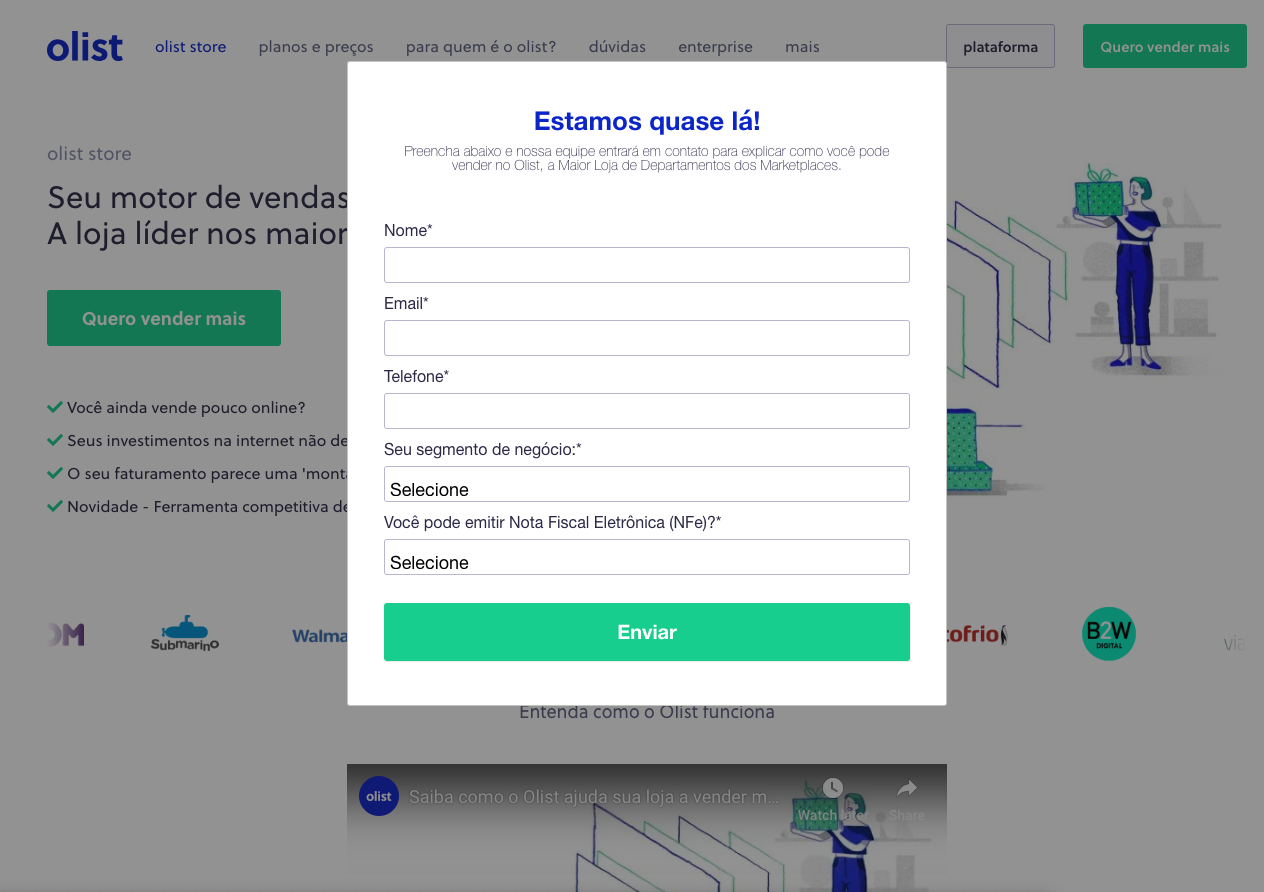

In [359]:
from IPython.display import Image
Image(filename='Data_Science_Marketing_Funnel_WEBFORM.png') 

## Context
    This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

    A seller join Olist through a marketing and sales funnel that was made public at this dataset. **Description of steps:**

        1. Sign-up at a landing page.
        2. Get contacted by a Sales development Representative (SDR), confirm some information and schedule a consultancy.
        3. Consultancy is made by a Sales Representative (SR). The SR may close the deal (lead sing up) or lose the deal (led leaves without sign in)
        4. Lead becomes a seller and starts building his catalog on Olist.
        5. His products are published on marketplaces and ready to sell!

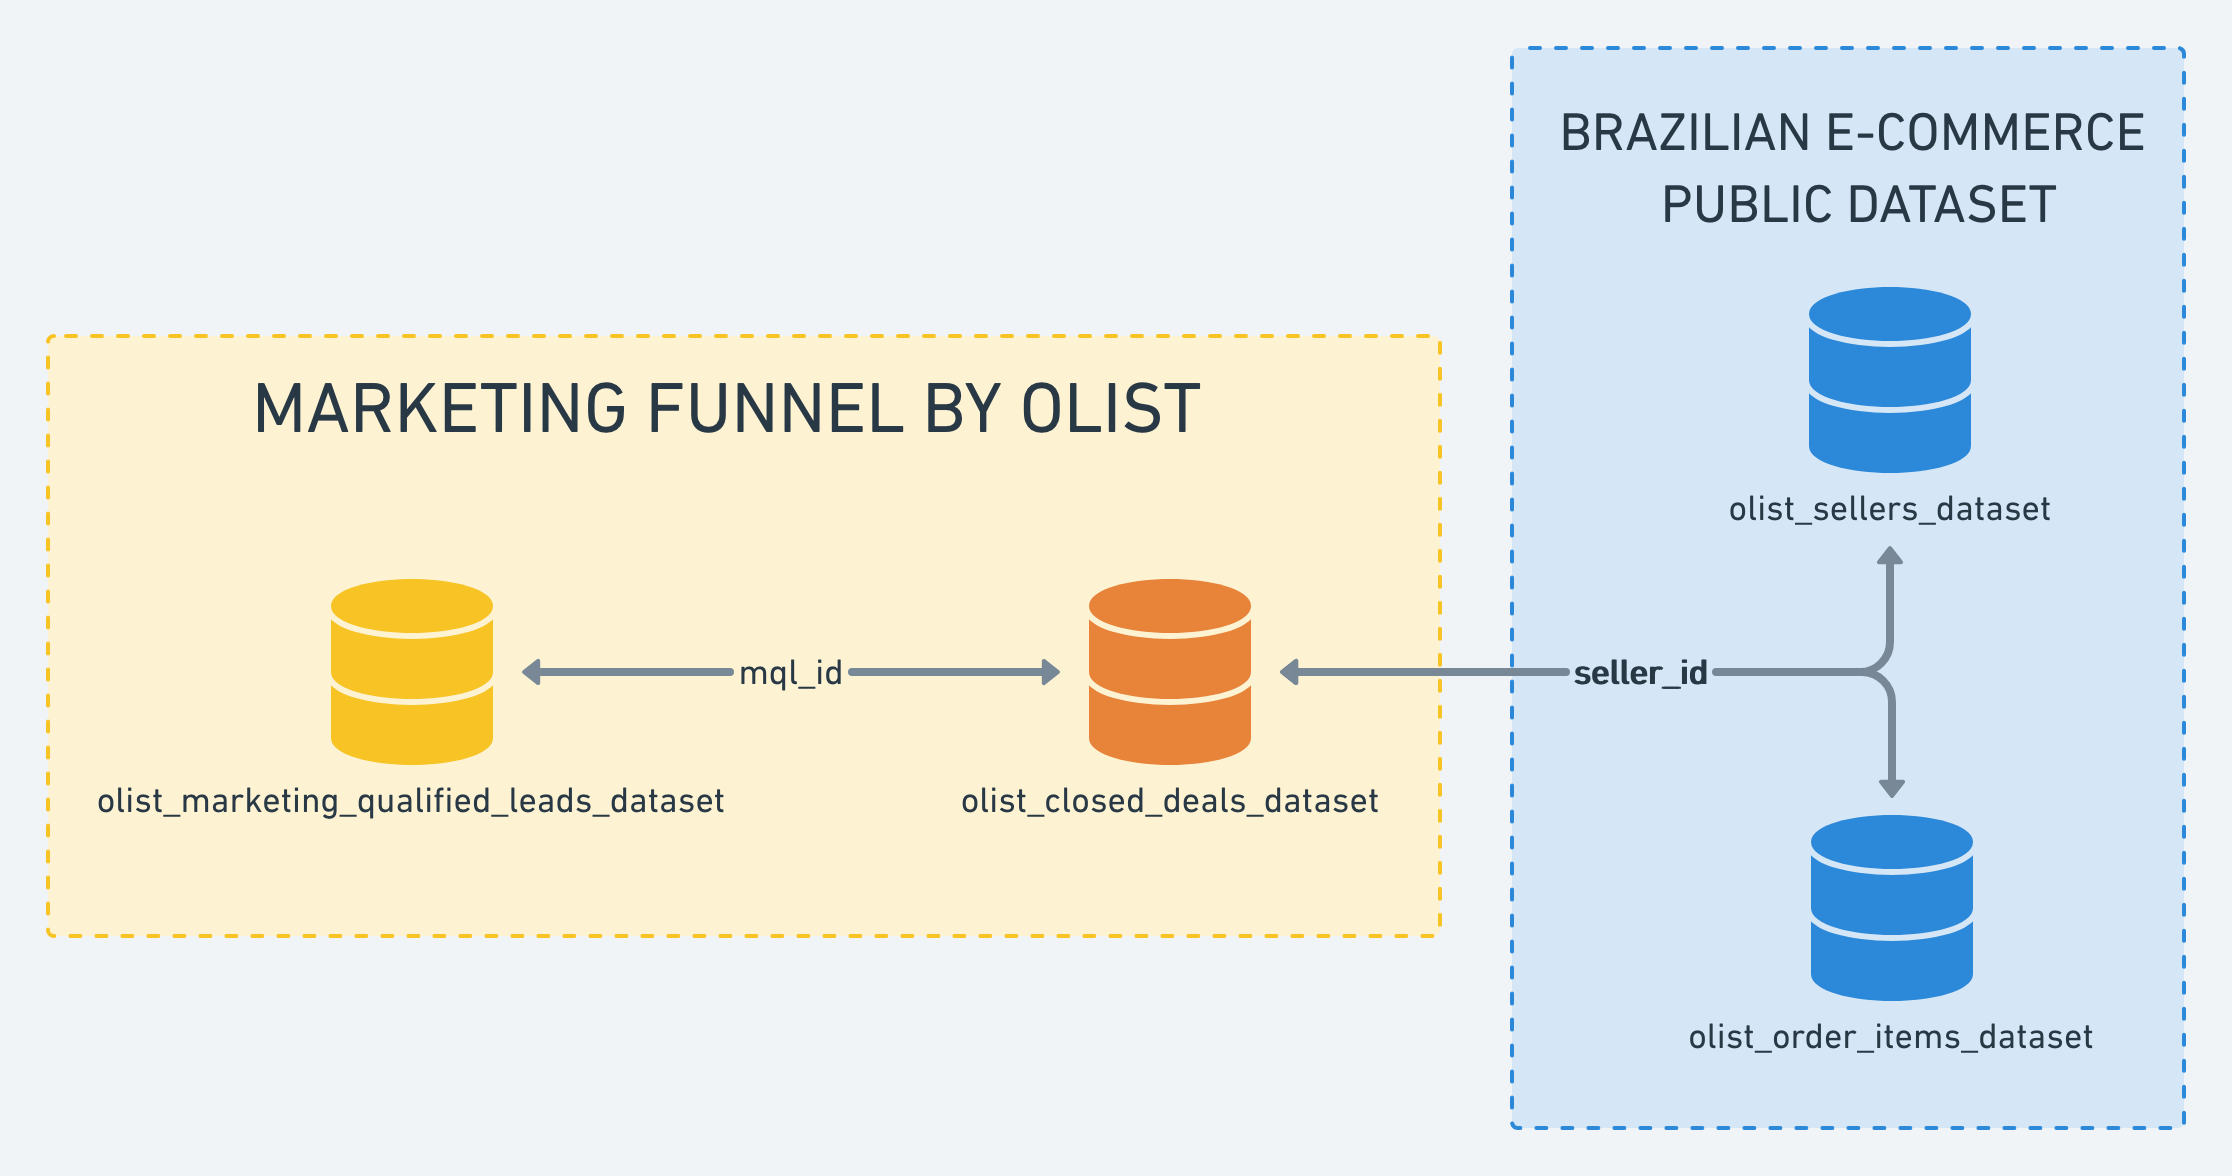

In [360]:
Image(filename='Data_Science_Marketing_Funnel_SCHEMA_DIAGRAM.png') 

# Exploratory Data Analysis

## Marketing Qualified Leads
After a lead fills in a form at a landing page, a filter is made to select the ones that are qualified to sell their products at Olist. They are the Marketing Qualified Leads (MQLs).

In [361]:
raw_data_mqls = pd.read_csv('olist_marketing_qualified_leads_dataset.csv')

In [362]:
raw_data_mqls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
mql_id                8000 non-null object
first_contact_date    8000 non-null object
landing_page_id       8000 non-null object
origin                7940 non-null object
dtypes: object(4)
memory usage: 250.1+ KB


In [363]:
list(raw_data_mqls.columns)

['mql_id', 'first_contact_date', 'landing_page_id', 'origin']

In [364]:
raw_data_mqls.describe(include='all').T

,count,unique,top,freq
mql_id,8000,8000,7c68935a1dfb1fc8fb714797e7cbf805,1
first_contact_date,8000,336,2018-05-02,93
landing_page_id,8000,495,b76ef37428e6799c421989521c0e5077,912
origin,7940,10,organic_search,2296


### Initial Data Analysis:

- As we saw in the data flow diagram above the "mql_id" will be our Primary Key to relate the MQL data to the Closed Leads dataset
- 'first_contact_date' will need to be handled in a unique way as there are 336 dates that would not supply value to our model independently of each other
- 'landing_page_id' looks to be of interest as the value: "b76ef37428e6799c421989521c0e5077" has ~912 leads generated by itself!
- With the organic_search having a high volume of leads generated we will also explore 'origin' categories

Lets dig into a few of these features a bit more:

### Origin


From our initial analysis we know organic_search is our main driver but we need to confirm if there are any other key features we might be interested in.

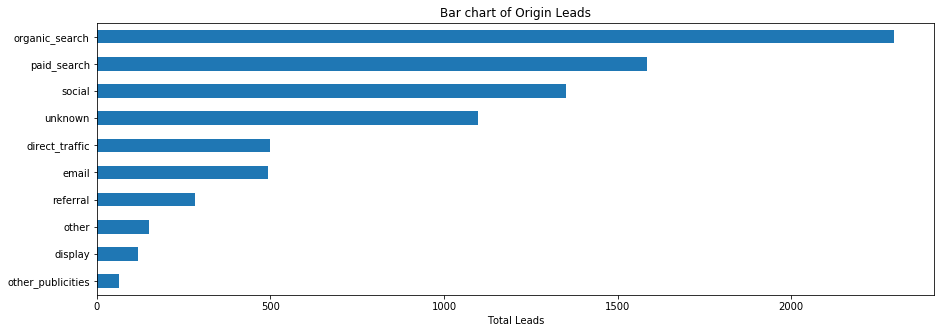

In [365]:
plt.figure(figsize=(15,5))
raw_data_mqls.origin.value_counts().sort_values().plot(kind = 'barh')
plt.title('Bar chart of Origin Leads')
plt.xlabel('Total Leads')

plt.show()

#### Interesting insights:

- Search (both organic + paid) are strong traffic drivers making up 2 out of the 3 of our top origin sources
- "Social" rounds out our T-3 performers but we do not (currently) have any description about what this is made up of (e.g. only Facebook? Does this include Twitter, Instagram, or other more nuanced platforms?)
- There are a large amount of "unknown" & "other" values that we may need to remove if they do not correlate to our closed deal records


_Lets move on_

### first_contact_date


Since this is going to be a classification model we need to transform our "first_contact_date" into features. Single days are too granular to break out into features so we will break these into "Year-Quarter" features.

In [366]:
# Convert first_contact_date into Year_Quarter feature
raw_data_mqls['first_contact_date'] = pd.to_datetime(raw_data_mqls['first_contact_date'])

raw_data_mqls['year_quarter'] = pd.PeriodIndex(raw_data_mqls.first_contact_date, freq='Q-DEC').strftime('%Y_Q%q')

print(raw_data_mqls.year_quarter.value_counts())

2018_Q1    3343
2018_Q2    2655
2017_Q4    1061
2017_Q3     937
2017_Q2       4
Name: year_quarter, dtype: int64


#### Insight

Very quickly we can see there could be some bias towards Q1 depending on how many of our leads closed in Q1. There is also a concern around seasonal data as we **only have 1 year of data** to review which could inadvertently skew our data.

### landing_page_id

Next we have the "landing pages" which are the pages that customers initially landed on on the website. Without knowing anything more than the page ids we will need to find a way to incorporate them in a different way. Let's see if there are any pages that truly shine above the rest:

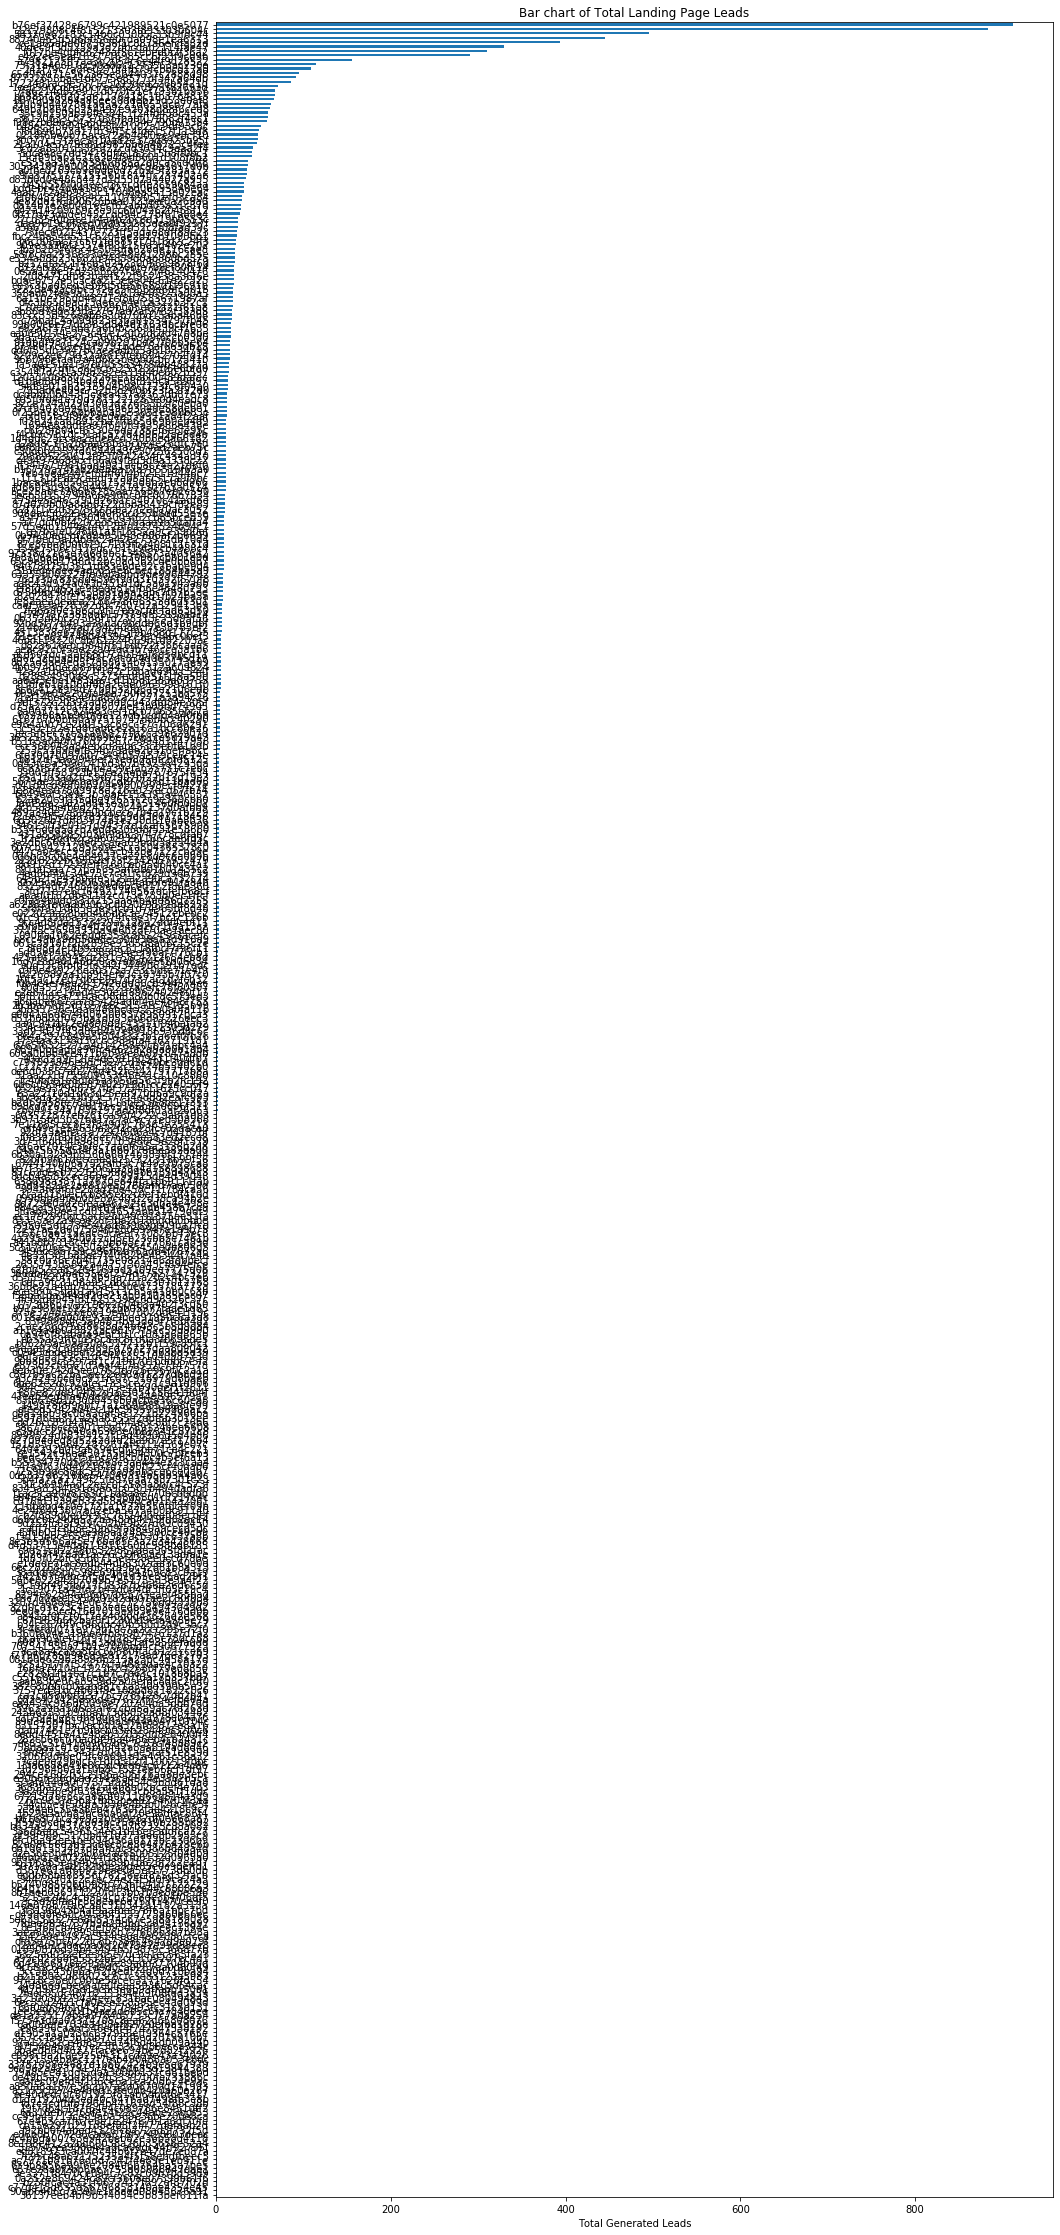

In [367]:
pd.set_option('display.max_rows', 1000)
raw_data_mqls.landing_page_id.value_counts().nlargest(n=25).sort_values(ascending=False)


plt.figure(figsize=(15,40))
raw_data_mqls.landing_page_id.value_counts().sort_values().plot(kind = 'barh')
# plt.xlim(912)
plt.title('Bar chart of Total Landing Page Leads')
plt.xlabel('Total Generated Leads')
plt.show()

In [368]:
raw_data_mqls.landing_page_id.value_counts().nlargest(n=100).sort_values(ascending=False)

b76ef37428e6799c421989521c0e5077    912
22c29808c4f815213303f8933030604c    883
58326e62183c14b0c03085c33b9fdc44    495
88740e65d5d6b056e0cda098e1ea6313    445
ce1a65abd0973638f1c887a6efcfa82d    394
40dec9f3d5259a3d2dbcdab2114fae47    330
f017be4dbf86243af5c1ebed0cff36a2    310
e492ee5eaf1697716985cc6f33f9cd9b    291
a7982125ff7aa3b2054c6e44f9d28522    156
73f31a40697cc90a86c1273563ac230e    115
241f79c7a8fe0270f4fb79fcbbcd17ad    109
65d9f9d71e562365e8b44037c2888d98     95
87732658ba41d8775e8577df347a64db     92
1722481ac9e5371e5099dea226b5421d     86
1ceb590cd1e00c7ee95220971f82693d     71
7fa6214d82e911d070f51ef79381b956     68
b6885f18d203a61176418c1fb3764815     67
007f9098284a86ee80ddeb25d53e0af8     66
330b9d44078a1ae5a221d655dcb77afa     63
649b7b8b46b254497e92038d88f6ced8     62
35c9b150ab36fe584c1f24fd458c453a     59
36120633c8737035fbabf079082f4ec1     59
f98c2bd96ac4a5d9476734e790c91384     58
b48ec5f3b04e9068441002a19df93c6c     51
f80696b73d17fb34f5c4fde157f119d8     49


#### Insight

We can see there are some interesting landing pages that we could use as initial features for our model but we need to keep in mind our model's goal which is to predict if a _lead will close_ which means we need to see which pages have the highest conversions of _closed leads_ VS _total generated leads_

# Closed MQL Deals Dataset

After a qualified lead fills in a form at a landing page he is contacted by a Sales Development Representative. At this step some information is checked and more information about the lead is gathered.

In [369]:
raw_data_closed_deals = pd.read_csv('olist_closed_deals_dataset.csv')

In [370]:
raw_data_closed_deals.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
mql_id,842,842,f4854d16f1c74c2e64a5b01933a04ada,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seller_id,842,842,ce616e1913288884e7742faac9d981db,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sdr_id,842,32,4b339f9567d060bcea4f5136b9f5949e,140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sr_id,842,22,4ef15afb4b2723d8f3d81e51ec7afefe,133,NaN,NaN,NaN,NaN,NaN,NaN,NaN
won_date,842,824,2018-05-04 03:00:00,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
business_segment,841,33,home_decor,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lead_type,836,8,online_medium,332,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lead_behaviour_profile,665,9,cat,407,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_company,63,2,True,58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_gtin,64,2,True,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Insights

- Need to create our Target feature by converting the _"won_date"_ to binary
- Will need to explore the following high volume closed leads for:
    - _sdr_id_ -> "4b339f9567d060bcea4f5136b9f5949e" ** makes up 16.6% of all closed leads **
    - _sr_id_ -> "4ef15afb4b2723d8f3d81e51ec7afefe" ** makes up 15.8% of all closed leads **
    - _business_segment_ -> "home_decor" ** makes up 12.5% of all closed leads **
    - _lead_type_ -> "online_medium" ** makes up 39.7% of all closed leads **
    - _lead_behaviour_profile_ -> "cat" ** makes up 61.2% of all closed leads **
    - _business_type_ -> "reseller" ** makes up 70.6% of all closed leads **




## Combining our 2 datasets

In [371]:
#Combine datasets to create a master table
mqls_df = pd.merge(raw_data_mqls, raw_data_closed_deals, how='left', on='mql_id', copy=True, indicator=True)

mqls_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 19 columns):
mql_id                           8000 non-null object
first_contact_date               8000 non-null datetime64[ns]
landing_page_id                  8000 non-null object
origin                           7940 non-null object
year_quarter                     8000 non-null object
seller_id                        842 non-null object
sdr_id                           842 non-null object
sr_id                            842 non-null object
won_date                         842 non-null object
business_segment                 841 non-null object
lead_type                        836 non-null object
lead_behaviour_profile           665 non-null object
has_company                      63 non-null object
has_gtin                         64 non-null object
average_stock                    66 non-null object
business_type                    832 non-null object
declared_product_catalog_size    69

In [372]:
mqls_df.head(100)

,mql_id,first_contact_date,landing_page_id,origin,year_quarter,seller_id,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,has_company,has_gtin,average_stock,business_type,declared_product_catalog_size,declared_monthly_revenue,_merge
0,dac32acd4db4c29c230538b72f8dd87d,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social,2018_Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,8c18d1de7f67e60dbd64e3c07d7e9d5d,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search,2017_Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,b4bc852d233dfefc5131f593b538befa,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search,2018_Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,6be030b81c75970747525b843c1ef4f8,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email,2018_Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,5420aad7fec3549a85876ba1c529bd84,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,2018_Q1,2c43fb513632d29b3b58df74816f1b06,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,NaN,NaN,NaN,reseller,NaN,0.0,both
5,28bdfd5f057764b54c38770f95c69f2f,2018-01-14,22c29808c4f815213303f8933030604c,organic_search,2018_Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6,126a0d10becbaafcb2e72ce6848cf32c,2018-05-15,6a110e795dd487f1cf8d7583671987af,email,2018_Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
7,f76136f54d14a3345951f25b7932366b,2018-05-24,d51b0d02f063ba1d053db6d97226eec3,email,2018_Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
8,2f838cade4a6012a6cb1016d1d8d95ed,2017-11-10,aeac92c0f5ae22a04ed3b746cce3a1b6,organic_search,2017_Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9,7281942387a1a0c3f72a50a8b0bb0920,2017-12-25,88740e65d5d6b056e0cda098e1ea6313,social,2017_Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [373]:
# Looks like there are a few fields we can remove as they are unique keys:
# mql_id, seller_id, _merge
mqls_df = mqls_df.drop(columns=['mql_id','seller_id','_merge'])

list(mqls_df)

['first_contact_date',
 'landing_page_id',
 'origin',
 'year_quarter',
 'sdr_id',
 'sr_id',
 'won_date',
 'business_segment',
 'lead_type',
 'lead_behaviour_profile',
 'has_company',
 'has_gtin',
 'average_stock',
 'business_type',
 'declared_product_catalog_size',
 'declared_monthly_revenue']

### Convert the "won_date" variable to our Target Feature: ** "closed" ** 

In [374]:
# win date to binary

mqls_df['closed'] = pd.notna(mqls_df.won_date)

mqls_df.closed.value_counts()

False    7158
True      842
Name: closed, dtype: int64

### Analyzing the ** "landing_page_id" ** by conversion rate of mql's to closed leads

In [375]:
# Calculate the highest converting 'landing_page_id' values to use
landing_pages_df = pd.DataFrame(mqls_df[mqls_df.closed == True].landing_page_id.value_counts().sort_values(ascending=False), columns=['closed_leads', 'leads', 'conversion_rate'])

landing_pages_df['closed_leads'] = mqls_df[mqls_df.closed == True].landing_page_id.value_counts()

landing_pages_df['leads'] = mqls_df.landing_page_id.value_counts()

landing_pages_df['conversion_rate'] = landing_pages_df.closed_leads / landing_pages_df.leads

landing_pages_df.sort_values(by=['conversion_rate', 'closed_leads'], ascending=False)

,closed_leads,leads,conversion_rate
6b6c0934205e87702519d1cce24055f9,2,2,1.000000
4e24f6443807ad2eba56754b0dc91140,1,1,1.000000
d387e61aff60919eae0a5ef1773db0db,1,1,1.000000
83355a82a9cee26f3ba2b186ddb0bbbe,1,1,1.000000
146e076b71a6ca8c31b34191182a313a,1,1,1.000000
3f3196b43b4af9aafbe878f6a1bbc7bd,1,1,1.000000
33751088e4687d1b6b2424b9e5e67979,1,1,1.000000
2635743d5842a4475730345cf894efce,1,1,1.000000
f55ba1da3448d20e213b0a10385eac07,1,1,1.000000
3e3371f8470ce094c7c82c09b7bd59d9,1,1,1.000000


In [376]:
top_performing_landing_pages = list(landing_pages_df.index)

# Create list of landing_page_id values to remove possibly remove as features
no_lead_landing_pages = pd.DataFrame(mqls_df[mqls_df.closed == False]['landing_page_id'])

no_lead_landing_pages['landing_page_id'] = 'landing_page_id_' + no_lead_landing_pages['landing_page_id']

no_lead_landing_pages = list(no_lead_landing_pages.landing_page_id)

#### Insight:
- After ordering the landing pages by highest _conversion_rate_ and _closed_leads_ totals we see that there are many pages that have a 100% _conversion_rate_ which could cause bias if we were to only take the top ~10 landing pages by _conversion_rate_. Due to this we will look into a feature selection model to identify features in a different way.
- To build our initial model we will use all pages that generated ** atleast 1 closed lead **

In [377]:
# Get dummy values for binary categorical fields
mqls_binary_dummies = pd.get_dummies(mqls_df[['has_company', 'has_gtin']], drop_first=True)

# Get dummy values for categorical fields
mqls_df_dummies = pd.get_dummies(mqls_df[['origin', 'business_segment', 'lead_type', 'lead_behaviour_profile', 'average_stock', 
                                          'business_type', 'year_quarter', 'sdr_id', 'sr_id', 'landing_page_id']])

list(mqls_df_dummies.columns)


ca6a69bdb3a354d4a',
 'landing_page_id_3e3371f8470ce094c7c82c09b7bd59d9',
 'landing_page_id_3f3196b43b4af9aafbe878f6a1bbc7bd',
 'landing_page_id_3fd71e7e6cf64921740567dcfefb68cf',
 'landing_page_id_40acf2a9cf2fe4de391609431f40dfb7',
 'landing_page_id_40dec9f3d5259a3d2dbcdab2114fae47',
 'landing_page_id_425a9f1cd945cb291c58c4212654eb8d',
 'landing_page_id_42a2a1be58277f162c18bad69bcc544f',
 'landing_page_id_431a558885d03bf98bc3747f78cdfab7',
 'landing_page_id_447cabeecc99dc245cb42be7122cba9e',
 'landing_page_id_44cb5e9f50dfa3b36e485b0f26c4fe5f',
 'landing_page_id_4513838e626b499f475f9b488d177c55',
 'landing_page_id_46bbd1ad032b44f18f1fb613200965a0',
 'landing_page_id_46bd119220c8bf61324669b1d82203ac',
 'landing_page_id_47a9f630d492167d7390ff23cf40dab6',
 'landing_page_id_47eeb9ed8fa40de028e33449896579a1',
 'landing_page_id_489a340e7e59e0bcbec67b4a19c1b229',
 'landing_page_id_4a295a87a340012cd5cb23cbb5e7461b',
 'landing_page_id_4aab772aeb9833c170d8ea5413e02eac',
 'landing_page_id_4b0974dd

In [378]:
# Remove 'landing_page_id's that do not have any closed leads
mqls_df_dummies.drop(no_lead_landing_pages, axis=1, inplace=True)

print(mqls_df_dummies.columns)

Index(['origin_direct_traffic', 'origin_display', 'origin_email',
       'origin_organic_search', 'origin_other', 'origin_other_publicities',
       'origin_paid_search', 'origin_referral', 'origin_social',
       'origin_unknown',
       ...
       'landing_page_id_df99f969c517db441d373ae68b2955c9',
       'landing_page_id_dff49c1e54630a22f1ca28fcc02daca0',
       'landing_page_id_e86b0b777206ca8a678f97428603deac',
       'landing_page_id_e873d2cf0661d3eaf417b952c7147578',
       'landing_page_id_e998c9a2c0e92504311cde9e43a34026',
       'landing_page_id_e9e396caabf546e0ff4f747b47538192',
       'landing_page_id_ea4434c9a6df0098e720204ba3dbb76d',
       'landing_page_id_ee40ded7dc801923f81ab6dbbf6e5417',
       'landing_page_id_f55ba1da3448d20e213b0a10385eac07',
       'landing_page_id_ffc62d6945fd1423539ec6d96326c37c'],
      dtype='object', length=164)


In [379]:
mqls_df_master = pd.concat([mqls_df,mqls_df_dummies, mqls_binary_dummies], axis=1)

mqls_df_master.head(20)

,first_contact_date,landing_page_id,origin,year_quarter,sdr_id,sr_id,won_date,business_segment,lead_type,lead_behaviour_profile,...,landing_page_id_e86b0b777206ca8a678f97428603deac,landing_page_id_e873d2cf0661d3eaf417b952c7147578,landing_page_id_e998c9a2c0e92504311cde9e43a34026,landing_page_id_e9e396caabf546e0ff4f747b47538192,landing_page_id_ea4434c9a6df0098e720204ba3dbb76d,landing_page_id_ee40ded7dc801923f81ab6dbbf6e5417,landing_page_id_f55ba1da3448d20e213b0a10385eac07,landing_page_id_ffc62d6945fd1423539ec6d96326c37c,has_company_True,has_gtin_True
0,2018-02-01,88740e65d5d6b056e0cda098e1ea6313,social,2018_Q1,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2017-10-20,007f9098284a86ee80ddeb25d53e0af8,paid_search,2017_Q4,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2018-03-22,a7982125ff7aa3b2054c6e44f9d28522,organic_search,2018_Q1,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2018-01-22,d45d558f0daeecf3cccdffe3c59684aa,email,2018_Q1,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,2018-02-21,b48ec5f3b04e9068441002a19df93c6c,organic_search,2018_Q1,a8387c01a09e99ce014107505b92388c,4ef15afb4b2723d8f3d81e51ec7afefe,2018-02-26 19:58:54,pet,online_medium,cat,...,0,0,0,0,0,0,0,0,0,0
5,2018-01-14,22c29808c4f815213303f8933030604c,organic_search,2018_Q1,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
6,2018-05-15,6a110e795dd487f1cf8d7583671987af,email,2018_Q2,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
7,2018-05-24,d51b0d02f063ba1d053db6d97226eec3,email,2018_Q2,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
8,2017-11-10,aeac92c0f5ae22a04ed3b746cce3a1b6,organic_search,2017_Q4,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
9,2017-12-25,88740e65d5d6b056e0cda098e1ea6313,social,2017_Q4,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [380]:
list(mqls_df_master.columns)

['first_contact_date',
 'landing_page_id',
 'origin',
 'year_quarter',
 'sdr_id',
 'sr_id',
 'won_date',
 'business_segment',
 'lead_type',
 'lead_behaviour_profile',
 'has_company',
 'has_gtin',
 'average_stock',
 'business_type',
 'declared_product_catalog_size',
 'declared_monthly_revenue',
 'closed',
 'origin_direct_traffic',
 'origin_display',
 'origin_email',
 'origin_organic_search',
 'origin_other',
 'origin_other_publicities',
 'origin_paid_search',
 'origin_referral',
 'origin_social',
 'origin_unknown',
 'business_segment_air_conditioning',
 'business_segment_audio_video_electronics',
 'business_segment_baby',
 'business_segment_bags_backpacks',
 'business_segment_bed_bath_table',
 'business_segment_books',
 'business_segment_car_accessories',
 'business_segment_computers',
 'business_segment_construction_tools_house_garden',
 'business_segment_fashion_accessories',
 'business_segment_food_drink',
 'business_segment_food_supplement',
 'business_segment_games_consoles',
 'bus

In [381]:
print(mqls_df_master.columns)

Index(['first_contact_date', 'landing_page_id', 'origin', 'year_quarter',
       'sdr_id', 'sr_id', 'won_date', 'business_segment', 'lead_type',
       'lead_behaviour_profile',
       ...
       'landing_page_id_e86b0b777206ca8a678f97428603deac',
       'landing_page_id_e873d2cf0661d3eaf417b952c7147578',
       'landing_page_id_e998c9a2c0e92504311cde9e43a34026',
       'landing_page_id_e9e396caabf546e0ff4f747b47538192',
       'landing_page_id_ea4434c9a6df0098e720204ba3dbb76d',
       'landing_page_id_ee40ded7dc801923f81ab6dbbf6e5417',
       'landing_page_id_f55ba1da3448d20e213b0a10385eac07',
       'landing_page_id_ffc62d6945fd1423539ec6d96326c37c', 'has_company_True',
       'has_gtin_True'],
      dtype='object', length=183)


## Model Preparation

In [382]:
# Initial features to use in model
bool_cols = [col for col in mqls_df_master 
             if np.isin(mqls_df_master[col].dropna().unique(), [0, 1]).all()]


print(np.count_nonzero(bool_cols))

169


### Identify features with high accuracy for predicting our Target of closed leads.

In [383]:
# Jaccard Similarity theorum to evaluate the relationship to the binary features

from sklearn.metrics import jaccard_similarity_score

In [384]:
# df to store results of Jaccard Similarity Scores for each Feature
js_scores_df = pd.DataFrame(data=None, columns = ['Predictive_Var' , 'JS_Score'])

mqls_df_master = mqls_df_master.fillna(0)

prediction_variables = list(mqls_df_master[bool_cols])

prediction_variables

['has_company',
 'has_gtin',
 'closed',
 'origin_direct_traffic',
 'origin_display',
 'origin_email',
 'origin_organic_search',
 'origin_other',
 'origin_other_publicities',
 'origin_paid_search',
 'origin_referral',
 'origin_social',
 'origin_unknown',
 'business_segment_air_conditioning',
 'business_segment_audio_video_electronics',
 'business_segment_baby',
 'business_segment_bags_backpacks',
 'business_segment_bed_bath_table',
 'business_segment_books',
 'business_segment_car_accessories',
 'business_segment_computers',
 'business_segment_construction_tools_house_garden',
 'business_segment_fashion_accessories',
 'business_segment_food_drink',
 'business_segment_food_supplement',
 'business_segment_games_consoles',
 'business_segment_gifts',
 'business_segment_handcrafted',
 'business_segment_health_beauty',
 'business_segment_home_appliances',
 'business_segment_home_decor',
 'business_segment_home_office_furniture',
 'business_segment_household_utilities',
 'business_segment_jewe

In [385]:
# df to store results of Jaccard Similarity Scores for each Feature
js_scores_df = pd.DataFrame(data=None, columns = ['Predictive_Var' , 'JS_Score'])

mqls_df_master = mqls_df_master.fillna(0)

prediction_variables = list(mqls_df_master[bool_cols])

# df to store model features
mql_model_df = mqls_df_master[prediction_variables]
mql_model_df = mql_model_df.drop(['has_company', 'has_gtin'], axis=1)

prediction_variables = mql_model_df.columns

for column_name in prediction_variables:
    y_pred = np.array(mql_model_df[column_name].astype(int))
    y_true = np.array(mql_model_df['closed'].astype(int))

    js_score = jaccard_similarity_score(y_true, y_pred)
    print(column_name + ' score generated')

    js_scores_df = js_scores_df.append({'Predictive_Var' : column_name, 'JS_Score' : js_score}, ignore_index=True)

closed score generated
origin_direct_traffic score generated
origin_display score generated
origin_email score generated
origin_organic_search score generated
origin_other score generated
origin_other_publicities score generated
origin_paid_search score generated
origin_referral score generated
origin_social score generated
origin_unknown score generated
business_segment_air_conditioning score generated
business_segment_audio_video_electronics score generated
business_segment_baby score generated
business_segment_bags_backpacks score generated
business_segment_bed_bath_table score generated
business_segment_books score generated
business_segment_car_accessories score generated
business_segment_computers score generated
business_segment_construction_tools_house_garden score generated
business_segment_fashion_accessories score generated
business_segment_food_drink score generated
business_segment_food_supplement score generated
business_segment_games_consoles score generated
business_seg

In [386]:
# Order Jaccard Similarity Scores by high to low for possible future feature reduction
js_scores_df = js_scores_df.sort_values(by='JS_Score', ascending=False).reset_index()

js_scores_df

,index,Predictive_Var,JS_Score
0,0,closed,1.000000
1,69,business_type_reseller,0.968125
2,52,lead_behaviour_profile_cat,0.945625
3,48,lead_type_online_medium,0.936250
4,67,business_type_manufacturer,0.925000
5,88,sdr_id_4b339f9567d060bcea4f5136b9f5949e,0.912250
6,114,sr_id_4ef15afb4b2723d8f3d81e51ec7afefe,0.911375
7,47,lead_type_online_big,0.910500
8,54,lead_behaviour_profile_eagle,0.910125
9,44,lead_type_industry,0.910125


#### Leveraging the Accuracy Scores for Feature Reduction
- As there are **8000** total records and **842** closed leads features that we would want to include in our model should have a _JS_Score_ of **atleast 89.47% or greater** (derived from: 842/8000)
- This score will be called our **feature_cutoff_score** which will equal **90%**

In [390]:
feature_cutoff_score = 0.9

# Basic feature analysis to confirm any bias does not exist / outliers / correlations
top_js_features = js_scores_df[js_scores_df.JS_Score > feature_cutoff_score]

top_js_features = list(top_js_features.Predictive_Var)

# top_js_features

mql_model_df = mql_model_df[top_js_features]

list(mql_model_df.columns)

['closed',
 'business_type_reseller',
 'lead_behaviour_profile_cat',
 'lead_type_online_medium',
 'business_type_manufacturer',
 'sdr_id_4b339f9567d060bcea4f5136b9f5949e',
 'sr_id_4ef15afb4b2723d8f3d81e51ec7afefe',
 'lead_type_online_big',
 'lead_behaviour_profile_eagle',
 'lead_type_industry',
 'business_segment_home_decor',
 'lead_type_offline',
 'lead_behaviour_profile_wolf',
 'business_segment_health_beauty',
 'sr_id_d3d1e91a157ea7f90548eef82f1955e3',
 'sdr_id_068066e24f0c643eb1d089c7dd20cd73',
 'lead_type_online_small',
 'business_segment_car_accessories',
 'sr_id_6565aa9ce3178a5caf6171827af3a9ba',
 'sdr_id_56bf83c4bb35763a51c2baab501b4c67',
 'business_segment_household_utilities',
 'business_segment_construction_tools_house_garden',
 'sdr_id_9d12ef1a7eca3ec58c545c678af7869c',
 'sr_id_85fc447d336637ba1df43e793199fbc8',
 'business_segment_audio_video_electronics',
 'sr_id_495d4e95a8cf8bbf8b432b612a2aa328',
 'sr_id_2695de1affa7750089c0455f8ce27021',
 'sdr_id_a8387c01a09e99ce01410750

### Insight:
- We can see that after calculating the jaccard similarity scores that none of the _general_ buckets that were initial categorical values are at the top of our accuracy list so we will remove those from the model to improve explainability and reduce overall features of our model.

In [392]:
# # We're going to remove variables that are unknown, other, or general buckets
# mql_model_df.drop(['origin_other', 'origin_unknown', 'business_segment_other', 'lead_type_other', 'average_stock_unknown'], axis=1)

In [393]:
mql_model_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
closed,8000,2,False,7158,NaN,NaN,NaN,NaN,NaN,NaN,NaN
business_type_reseller,8000,NaN,NaN,NaN,0.073375,0.260767,0,0,0,0,1
lead_behaviour_profile_cat,8000,NaN,NaN,NaN,0.050875,0.219756,0,0,0,0,1
lead_type_online_medium,8000,NaN,NaN,NaN,0.0415,0.199456,0,0,0,0,1
business_type_manufacturer,8000,NaN,NaN,NaN,0.03025,0.171285,0,0,0,0,1
sdr_id_4b339f9567d060bcea4f5136b9f5949e,8000,NaN,NaN,NaN,0.0175,0.131133,0,0,0,0,1
sr_id_4ef15afb4b2723d8f3d81e51ec7afefe,8000,NaN,NaN,NaN,0.016625,0.12787,0,0,0,0,1
lead_type_online_big,8000,NaN,NaN,NaN,0.01575,0.124515,0,0,0,0,1
lead_behaviour_profile_eagle,8000,NaN,NaN,NaN,0.015375,0.123047,0,0,0,0,1
lead_type_industry,8000,NaN,NaN,NaN,0.015375,0.123047,0,0,0,0,1


## Feature analysis to confirm if there is any multicolinearity between features

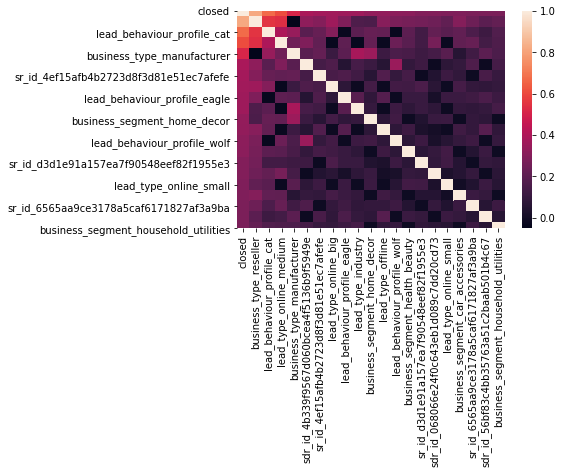

In [394]:
# Basic feature analysis to confirm any bias does not exist / outliers / correlations
top_js_features = js_scores_df.sort_values(by='JS_Score', ascending=False)[:21]

top_js_features = list(top_js_features.Predictive_Var)

# top_js_features

# Break down  
#   To answer the question of "How high is too high for multicolinearity?"
#       https://www.researchgate.net/post/Whats_the_difference_between_correlation_and_VIF
sns.heatmap(mql_model_df[top_js_features].corr())

#### Insight:
- From our analysis above we can confirm that there is minimal multicolinearity between our features
- We also noticed that our T-3 Features are much higher in accuracy scores than the rest of our features which we could explore in the future

### Normalize our Model Features

In [410]:
mql_model_df_normalized = mql_model_df.drop(['closed'], axis=1)

mql_model_df_normalized.shape

(8000, 36)

In [411]:
# Normalize features that will be used

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X = mql_model_df_normalized

X = StandardScaler().fit_transform(X)


# Implement PCA to reduce Model Features
sklearn_pca = PCA(n_components=20)

Z = sklearn_pca.fit_transform(X)

feat_cols = ['feature' + str(i) for i in range(Z.shape[1])]
mql_model_df_pca = pd.DataFrame(Z, columns=feat_cols)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_,

    sklearn_pca.explained_variance_ratio_.sum()
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.12973186 0.05250124 0.04192633 0.03974788 0.03919151 0.03772
 0.03491642 0.03399018 0.03270156 0.03212077 0.03170875 0.03102503
 0.02967695 0.02918062 0.02865151 0.02825799 0.02679251 0.02649621
 0.02616014 0.02565405] 0.7581515061507021


#### We have run our features through PCA to reduce our total feature count by close to half (~90) which will help scale the model when more leads are added overtime. Through this process we werew also able to maintain just over ~75% of our variance explained by the generated features. 
- this supports creating a diverse set of features that generates a more robust model

In [405]:
# print(mql_model_df_normalized.shape)

# mql_model_df_normalized.head()

## Testing our Models

### Random Forest Model
We chose to use a Random Forest Model since this is a classification model and it has a proven track record of performing well when given a finite amount of outcomes (such as our example here of _"did the lead close or not?"_ )

In [428]:
# Implement Random Forest Model

from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = mql_model_df_pca
# X = mql_model_df.drop('closed', axis=1)
y = mql_model_df.closed

cross_val_score(rfc, X, y, cv=10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Model Results
- Our Cross Validation results came back extremely high which we are cautious about accepting at face value but it could be a good sign for our model. We increased our original amount of cross validations from 5 to 10 to confirm results were not skewed.
- Even though random forest models provide less transparency in terms of how we arrive at our results we have already run our model features through PCA which already has reduced the transparency.

### Gradient Boosted Model

We chose to use Gradient Boosted Model as our second model to compare performance to the Random Forest Model so that we could use some of the built in feature analysis tools that come out of the box with the Gradient Boosted Modeling technique such as _feature_importance()_ so we can get better idea of what might be causing the possible skewed results.

In [429]:
# Import Modules for scikit learn
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [430]:
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0


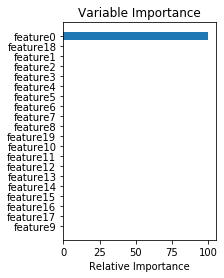

In [431]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Model Results:
- Interesting results! It looks like our Gradient Boosted Model is leveraging our first feature ** feature0 ** quite a bit but we do not know which features might be making up that PCA feature. Lets dive a bit deeper to review what features if we were to let our model run using our original list of features that it would use most frequently in our model.
- Low errors from both our Training and Test Sets for accuracy confirm our features are strong and should be ready for use in a production model.

In [434]:
X = mql_model_df.drop('closed', axis=1)
y = mql_model_df.closed

offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0025


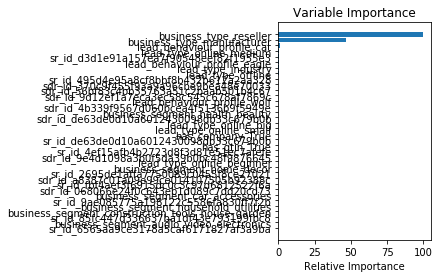

In [435]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Insight:
- Aha! We can now see that our _'business_type_reseller','lead_behaviour_profile_cat','lead_type_online_medium'_ original features are being bagged into _feature0_ which is leading to the model not using any of our other features.


### Model Results
Our model performs at a phenomenally which might point to a bias in the model that we have not uncovered yet. With that caveat in mind we will choose to move forward with the Gradient Boosted Model due to the strong training and test set accuracy scores. 

## The practical uses of your model for an audience of interest

Depending on how frequently you run this model, it could be used to predict leads sales development reps, sales reps, and marketing channel performance on quantity of leads closed (aka "win rate") down to possibly a daily basis! It could also be used for identifying industry trends based on customer types using business_segment, business_type, lead_type which all have values that show high accuracy to predicting if a mql will close or not.

## Any weak points or shortcomings of your model?
- There is another dataset as per the ecommerce schema above to add in for next iteration of project
- Consistent retraining of the model will be required due to high likelihood of "model drift" as more leads are collected the distributions will change as industry trends change
- A higher volume of leads might start to bias the model if we the model does not contain even distributino of samples of leads over the quarters provided?
- As we see that there were over 8k in leads as just a sample dataset, this model will require more computational power to run overtime which we could run into computational complexity problems with the Gradient Boosted Model
- Discounts or coupon data was not provided running at the time of generating this model which could introduce bias to specific marketing channels & or lead types.

### Future Projects:

- Examining / Evaluating Clustering
- Did any Sales Representatives leave the company during the sample dataset timeframe?


#### Future feature theory:
As businesses could  run on a quarter by quarter basis, creating features such as the following should encapsulate possible trends:
- "BOQ" ("Beginning of Quarter") -> first month of each quarter
- "MOQ" (Middle of Quarter) -> second month of each quarter
- "EOQ" ("End of Quarter")  -> third month of each quarter
- "BOM" + "MOM" + "EOM" ("Beginning of Month" + "Middle of Month" + "End of Month")